In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Layer, Multiply, Reshape, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from google.colab import files

In [ ]:
# Install Kaggle library and prepare directory
!pip install -q kaggle
!mkdir -p ~/.kaggle

# Upload Kaggle API key
from google.colab import files
files.upload()

# Rename the uploaded file to kaggle.json
import os
os.rename("kaggle (6).json", "kaggle.json")  # Replace with your actual uploaded filename

# Move it to the correct location and set permissions
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip


Saving kaggle (6).json to kaggle (6) (1).json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [ ]:
# Set data directory
data_dir = "/content"

# Load metadata
df_meta = pd.read_csv(os.path.join(data_dir, "HAM10000_metadata.csv"))

# Select only the required classes: 'df', 'vasc', 'akiec'
selected_classes = ['df', 'vasc', 'akiec']
df_meta = df_meta[df_meta['dx'].isin(selected_classes)].reset_index(drop=True)

# Collect all image paths from both directories
image_paths = glob('/content/HAM10000_images_part_1/*.jpg') + glob('/content/HAM10000_images_part_2/*.jpg')

# Create a dictionary mapping image IDs to their full paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in image_paths
}

# Map image paths to the metadata dataframe
df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)

# Check for missing paths
if df_meta['path'].isnull().any():
    print("Some images are missing from the provided directories!")
    missing_ids = df_meta[df_meta['path'].isnull()]['image_id'].tolist()
    print(f"Missing image IDs: {missing_ids}")

# Map categorical labels to numeric values
label_mapping = {label: idx for idx, label in enumerate(selected_classes)}
df_meta['label'] = df_meta['dx'].map(label_mapping)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df_meta, stratify=df_meta['label'], test_size=0.2, random_state=42)

# Augmentation parameters

In [ ]:
# Augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images
augmented_dir = os.path.join(data_dir, "augmented_images")
os.makedirs(augmented_dir, exist_ok=True)

def augment_and_save_images(df, imgs_to_generate=500):
    augmented_data = []

    for class_label in df['label'].unique():
        class_data = df[df['label'] == class_label]
        img_count = len(class_data)

        for i in range(imgs_to_generate):
            img_path = class_data.iloc[i % img_count]['path']
            img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            augmented_images = datagen.flow(img_array, batch_size=1)
            for aug_img in augmented_images:
                save_path = os.path.join(augmented_dir, f"{class_label}_{i}.jpg")
                tf.keras.preprocessing.image.save_img(save_path, aug_img[0])
                augmented_data.append((save_path, class_label))
                break

    return pd.DataFrame(augmented_data, columns=['path', 'label'])


In [ ]:
# Augment training data
augmented_train_df = augment_and_save_images(train_df)

# Combine augmented data with original training data
train_df_combined = pd.concat([train_df[['path', 'label']], augmented_train_df], ignore_index=True)

# Convert 'label' column to string
train_df_combined['label'] = train_df_combined['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


In [ ]:
train_gen = datagen.flow_from_dataframe(
    train_df_combined,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Changed target size to (224, 224)
    class_mode='categorical',
    batch_size=32
)

val_gen = ImageDataGenerator().flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Changed target size to (224, 224)
    class_mode='categorical',
    batch_size=32
)


Found 1967 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, Multiply # Import Conv2D

In [ ]:
# Build model with VGG19 + attention mechanism
input_tensor = Input(shape=(224, 224, 3))
base_model = VGG19(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = False

x = base_model.output

# Attention mechanism (spatial)
attn = Conv2D(512, kernel_size=1, activation='relu')(x)
attn = Conv2D(1, kernel_size=1, activation='sigmoid')(attn)
x = Multiply()([x, attn])

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(len(selected_classes), activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 28, 28,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv4[0][

 Total params: 20,419,652 (77.89 MB)

 Trainable params: 395,268 (1.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint
checkpoint_path = os.path.join(data_dir, "vgg19_attention_best_model.keras")
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Load training history
history_file = 'vgg19_attention_train_history.pkl'

def load_history():
    try:
        with open(history_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Training parameters
total_epochs = 100
epochs_per_session = 100
initial_epoch = len(load_history()['accuracy'])

# Incremental training
while initial_epoch < total_epochs:
    print(f"\nStarting training from epoch {initial_epoch} to {initial_epoch + epochs_per_session}")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=initial_epoch + epochs_per_session,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint, reduce_lr]
    )

    prev_history = load_history()
    for key in history.history:
        if key in prev_history:
            prev_history[key].extend(history.history[key])
        else:
            prev_history[key] = history.history[key]

    with open(history_file, 'wb') as f:
        pickle.dump(prev_history, f)

    initial_epoch += epochs_per_session
    print(f"Completed {initial_epoch} epochs. Training progress saved.\n")

# Final evaluation
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Final Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Starting training from epoch 0 to 100
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4310 - loss: 1.0757
Epoch 1: val_loss improved from inf to 0.84528, saving model to /content/vgg19_attention_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 551ms/step - accuracy: 0.4332 - loss: 1.0726 - val_accuracy: 0.7436 - val_loss: 0.8453 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.8429 - loss: 0.5520
Epoch 2: val_loss improved from 0.84528 to 0.68869, saving model to /content/vgg19_attention_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 514ms/step - accuracy: 0.8430 - loss: 0.5514 - val_accuracy: 0.8034 - val_loss: 0.6887 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8747 - loss: 0.4277
Epoch 3: val_loss improved from 0.68869 to 0.63171, saving model to /content/vgg19_attention_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 523ms/step - accuracy: 0.8747 - loss: 0.4277 - val_accuracy

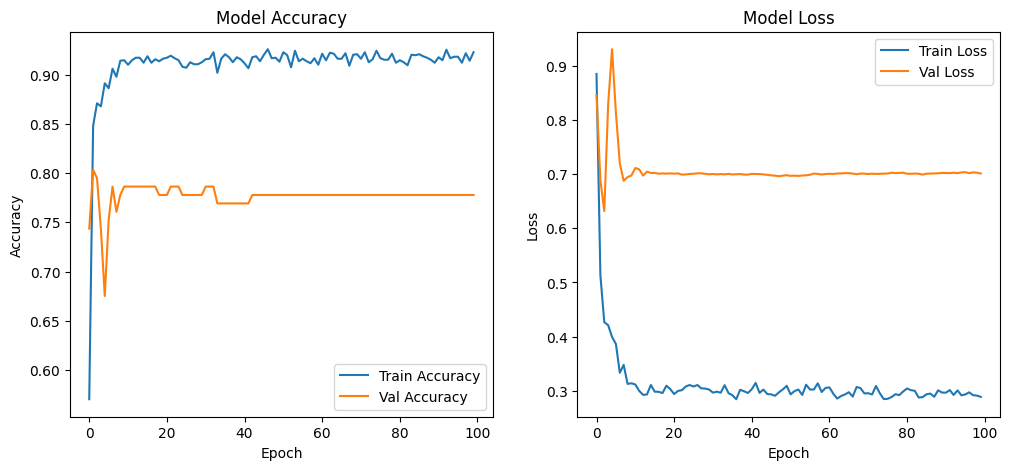

In [ ]:
# Plot training history
with open(history_file, 'rb') as f:
    final_history = pickle.load(f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['accuracy'], label='Train Accuracy')
plt.plot(final_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['loss'], label='Train Loss')
plt.plot(final_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()